In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import statsmodels

%matplotlib inline

In [2]:
versions = {
    'pandas' : pd.__version__,
    'requests': requests.__version__,
    'numpy' : np.__version__,
    'matplotlib' : matplotlib.__version__,
    'statsmodels' : statsmodels.__version__}
print(versions)


{'pandas': '0.24.0', 'requests': '2.21.0', 'numpy': '1.15.4', 'matplotlib': '3.0.2', 'statsmodels': '0.9.0'}


In [3]:
def dummy_prep(data, method=None, error_none=True):
    varlist = data.select_dtypes(include='category').columns
    if len(varlist) == 0 and error_none: return
    if len(varlist) == 0 and not error_none: raise ValueError('dummy_prep expects a categoricical variable')
    if not method: 
        return pd.get_dummies(data[varlist])
    if method == 'drop_first':
        return pd.get_dummies(data[varlist], drop_first=True)
    if method == 'deviation':
        dummies = pd.get_dummies(data[varlist])
        dummylist = {i:[x for x in dummies.columns if i in x] for i in varlist}
        for var in dummylist:
            dropout = dummylist[var][0]
            keepers = dummylist[var][1:]
            dummies.loc[dummies[dropout]==1, keepers] = -1
            del dummies[dropout]
        dummies.replace(255,-1,inplace=True)
        return dummies
    
def features_prep(data, dummy_method=None):
    if sum(data.dtypes=='object') > 0: raise ValueError(
        'Data should have object dtypes replaced with categoricals'
        ' or otherwise cleaned before running feature_prep function')
    categoricals = dummy_prep(data, method=dummy_method)
    numericals = data.select_dtypes(exclude=['object','category'])
    return pd.concat([numericals, categoricals], axis=1)

def rsquared(x, p):
    mean = x.mean()
    sstot = sum((x-mean)*(x-mean))
    ssres = sum((x-p)*(x-p))
    return 1 - ssres / sstot

def aic(x,p, k):
    ssres = sum((x-p)**2)
    aic = 2 * k - 2 * np.log(ssres)
    return aic

In [4]:
data_vals = requests.request(method='GET',url='http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
df = pd.read_fwf('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', header=None)
df.columns=['mpg','cylinders','displacement',
            'horsepower','weight','acceleration',
            'model_year','origin','car_name']
df['horsepower_int'] = pd.to_numeric(df.horsepower,errors='coerce')
df['car_name'] = pd.Categorical(df.car_name)
df['origin'] = pd.Categorical(df.origin)
df['model_year'] = pd.Categorical(df.model_year)
df['cylinder'] = pd.Categorical(df.cylinders)
del df['horsepower']
df_clean = df.dropna()

target = df_clean[['mpg']]
features_v1 = df_clean[[x for x in df.columns if x != 'mpg' and x != 'car_name']]
features_v2 = df_clean[[x for x in df.columns if x != 'mpg']]
df_clean.dtypes

mpg                float64
cylinders            int64
displacement       float64
weight             float64
acceleration       float64
model_year        category
origin            category
car_name          category
horsepower_int     float64
cylinder          category
dtype: object

# EDA

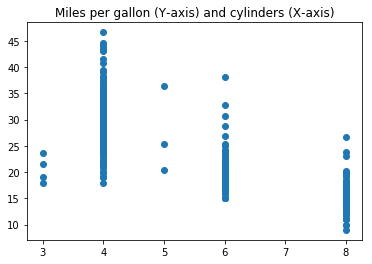

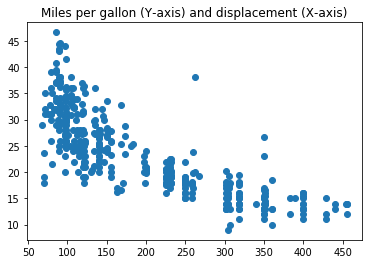

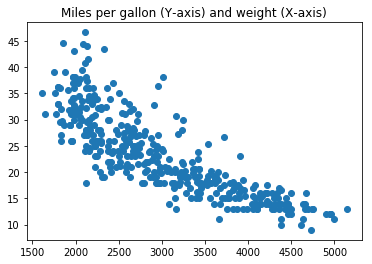

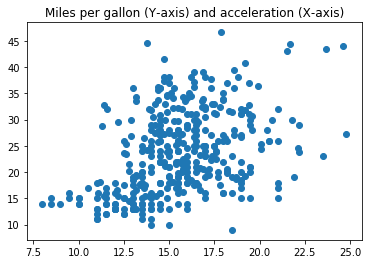

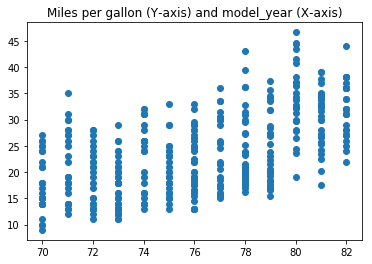

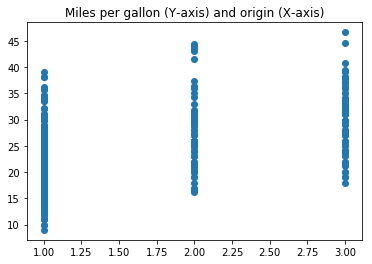

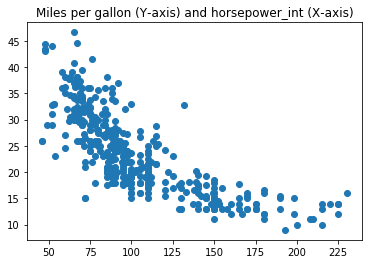

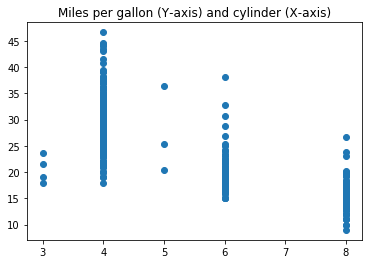

mpg                float64
cylinders         category
displacement       float64
weight             float64
acceleration       float64
model_year        category
origin            category
car_name          category
horsepower_int     float64
cylinder          category
dtype: object

In [5]:
for n, var in enumerate(features_v1.columns):
    plt.scatter( x=features_v1[var],y=target.mpg)
    plt.title('Miles per gallon (Y-axis) and {} (X-axis)'.format(var))
    plt.show()
    
# for n, var in enumerate(features_v1.columns):
#     print('Variance Inflaction Factor for {}: '.format(var), vif(features_v1.values, n))
    
# We see cynlinders, origin, and possibly model year are categorical variables.
# Cylinders we know is ordinal, though the relationship to MPG may not be linear in E(MPG | Cylinder count)
# Origin appears to be an encoded variables
# Model-year is ordinal, and masks a lot of things like improving legal efficiency standards, or perhaps depreciation in performance
# Hence, turning these to categorical
df['origin'] = pd.Categorical(df.origin)
df['cylinders'] = pd.Categorical(df.cylinders)
df['model_year'] = pd.Categorical(df.model_year)
target = df_clean[['mpg']]
features_v1 = df_clean[[x for x in df.columns if x != 'mpg' and x != 'car_name']]
features_v2 = df_clean[[x for x in df.columns if x != 'mpg']]
df.dtypes

In [6]:
def dummy_prep(data, method=None):
    varlist = data.select_dtypes(include='category').columns
    if not method: 
        return pd.get_dummies(data.select_dtypes(include='category'))
    if method == 'drop_first':
        return pd.get_dummies(data.select_dtypes(include='category'), drop_first=True)
    if method == 'deviation':
        dummies = pd.get_dummies(data.select_dtypes(include='category'))
        dummylist = {i:[x for x in dummies.columns if i in x] for i in varlist}
        for var in dummylist:
            dropout = dummylist[var][0]
            keepers = dummylist[var][1:]
            dummies.loc[dummies[dropout]==1, keepers] = -1
            del dummies[dropout]
        dummies.replace(255, -1, inplace=True) #Error handling random 255 values instead of -1 -- something with unsigned ints maybe
        return dummies
    
def features_prep(data, dummy_method = None):
    if sum(data.dtypes == 'object') != 0: raise ValueError(
        'Data preprocessing should convert all non-numeric '
        'variables to categorical. Check input data types.'
    )
    categoricals = dummy_prep(data, dummy_method)
    numericals = data.select_dtypes(exclude=['category','object'])
    return pd.concat([numericals, categoricals], axis=1)
    

    

# Modeling

In [7]:
msk = (np.random.rand(len(df_clean)) < .8)
df_clean['noise1'] = (np.random.rand(len(df_clean)) < .8)
df_clean['noise2'] = (np.random.rand(len(df_clean)) < .8)
df_clean['noise3'] = (np.random.rand(len(df_clean)) < .8)
train = df_clean.loc[msk,:].copy(deep=True)
test = df_clean.loc[~msk, :].copy(deep=True)

models = {
#     0 : 'mpg ~ 1',
    1 : 'mpg ~ weight',
    2 : 'mpg ~ weight + displacement',
    3 : 'mpg ~ weight + displacement + np.log(acceleration)',
    4 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int)',
    5 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum)',
    6 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum)',
    7 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum) + C(origin, Sum)',
    8 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum) + C(origin, Sum) + C(car_name, Sum)',
    9 : 'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum) + C(origin, Sum) + C(car_name, Sum) + noise1',
    10 :'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum) + C(origin, Sum) + C(car_name, Sum) + noise1 + noise2',
    11 :'mpg ~ weight + displacement + np.log(acceleration) + np.log(horsepower_int) + C(cylinders, Sum) + C(model_year, Sum) + C(origin, Sum) + C(car_name, Sum) + noise1 + noise2 + noise3',
}

/home/brute/apps/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/brute/apps/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/brute/apps/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [8]:
class Validation_fits():
    def __init__(self, results):
        self.train_results = results
        self.regressand = results.summary().tables[0].data[0][1]
    
    def ssres(self, test=None):
        if test is None: return self.train_results.ssr
        else: return sum((test[self.regressand] - self.train_results.predict(test))**2)
    
    def aic(self, test=None):
        if test is None: aic = self.train_results.aic
        else: 
            aic = 2 * self.train_results.df_resid + self.train_results.nobs * (1 + np.log(np.pi) + 
                np.log(self.ssres(test)))
        return aic
    
    def rsquared(self, test=None):
        if test is None: return self.train_results.rsquared
        else:
            m = test[self.regressand].mean()
            return 1 - self.ssres(test=test)/sum((test[self.regressand]-m)**2)


train_results = []
test_results = []
for model in models:
    results = smf.ols(
        models[model]
    , data=train).fit()
    v = Validation_fits(results)
    train_results.append(results.ssr/len(train))
    test_results.append(v.ssres(test)/len(test))

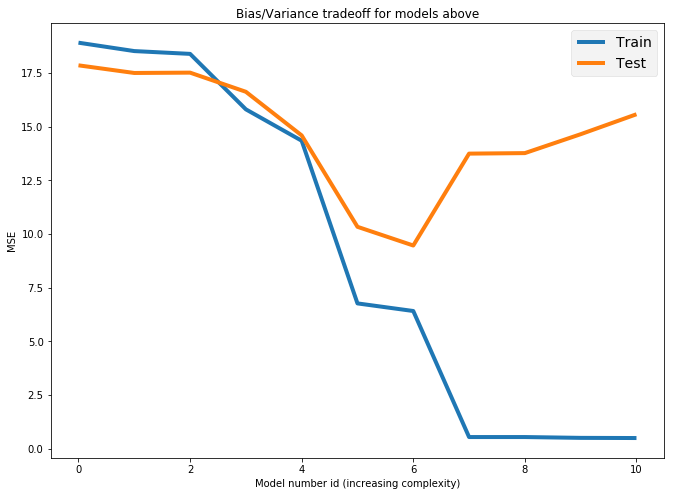

In [9]:
plt.figure(figsize=(11,8))
plt.title('Bias/Variance tradeoff for models above')
plt.style.use('fivethirtyeight')
plt.plot(range(len(train_results)), train_results)
plt.plot(range(len(test_results)), test_results)
plt.xlabel('Model number id (increasing complexity)')
plt.ylabel('MSE')
plt.legend(['Train','Test'])

plt.savefig('/home/brute/Dropbox/Writing/Blog/andana/assets/images/20190111_bias_variance.png', format='png')
plt.show()

In [10]:
results = smf.ols(models[4], data=train).fit()
x = results.summary()
print(x.as_html())

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>           <td>mpg</td>       <th>  R-squared:         </th> <td>   0.734</td>
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.731</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   215.0</td>
</tr>
<tr>
  <th>Date:</th>             <td>Sun, 27 Jan 2019</td> <th>  Prob (F-statistic):</th> <td>3.43e-88</td>
</tr>
<tr>
  <th>Time:</th>                 <td>11:02:24</td>     <th>  Log-Likelihood:    </th> <td> -884.48</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>   316</td>      <th>  AIC:               </th> <td>   1779.</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   311</td>      <th>  BIC:               </th> <td>   1798.</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     4</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th

In [11]:
results.nobs

316.0

In [12]:
print(results.mse_model, results.mse_resid, results.mse_total, results.ssr/len(train))

3451.137982782953 16.05522752006947 59.675325999598144 15.801189109941788


In [21]:
dd = pd.DataFrame(test_results, columns=['Test_Results'])
dd['Train_Results'] = train_results
dd.to_csv('results.csv', index=False)